In [1]:
%matplotlib widget
# %pylab
import happi

In [15]:
from scipy.signal import butter,filtfilt
from scipy import fftpack
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.collections import LineCollection
# from matplotlib.colors import ListedColormaplormap, BoundaryNorm, LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable,axes_size
from matplotlib.ticker import LogLocator
# from matplotlib.colors import LogNorm

#possible legend locations
leg_loc = {0: "best",
           1: "upper right",
           2: "upper left",
           3: "lower left",
           4: "lower right",
           5: "right",
           6: "center left",
           7: "center right",
           8: "lower center",
           9: "upper center",
           10: "center"}

# plt.rc('text', usetex=True)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12#20
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.loc'] = leg_loc[0]

jetcmap = plt.cm.get_cmap("jet", 9) #generate a jet map with 10 values "rainbow", "jet"
jet_vals = jetcmap(np.arange(9)) #extract those values as an array 
jet_vals[0] = [1.0, 1, 1.0, 1] #change the first value 
newcmap = mpl.colors.LinearSegmentedColormap.from_list("mine", jet_vals) 

# prepare constants and units
me = 9.1e-31
mp = 1836.*me
qe = 1.6e-19
c  = 3e8               # Light speed
wr = 2*np.pi*c/1.0e-6    # This normalization frequency is particularly for our case
                       # You can get it from S.namelist.w_r
de = c/wr              # electron skin-depth

/var/folders/px/lygg4lfs0b52bcyl348z_33c0000gp/T/ipykernel_36466/837687337.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jetcmap = plt.cm.get_cmap("jet", 9) #generate a jet map with 10 values "rainbow", "jet"


In [9]:
wkdir = ['/Volumes/LaCie/Magnetized_LPI_Single_Speckle/MLPI2D_test0_b0/',
         '/Volumes/LaCie/Magnetized_LPI_Single_Speckle/MLPI2D_test0_b20/']

In [7]:
S0 = happi.Open('/Volumes/LaCie/Magnetized_LPI_Single_Speckle/MLPI2D_test0_b0/')
S1 = happi.Open('/Volumes/LaCie/Magnetized_LPI_Single_Speckle/MLPI2D_test0_b20/')

Loaded simulation '/Volumes/LaCie/Magnetized_LPI_Single_Speckle/MLPI2D_test0_b0/'
Scanning for Scalar diagnostics
Scanning for Field diagnostics
Scanning for Probe diagnostics
Scanning for ParticleBinning diagnostics
Scanning for RadiationSpectrum diagnostics
Scanning for Performance diagnostics
Scanning for Screen diagnostics
Scanning for Tracked particle diagnostics
Loaded simulation '/Volumes/LaCie/Magnetized_LPI_Single_Speckle/MLPI2D_test0_b20/'
Scanning for Scalar diagnostics
Scanning for Field diagnostics
Scanning for Probe diagnostics
Scanning for ParticleBinning diagnostics
Scanning for RadiationSpectrum diagnostics
Scanning for Performance diagnostics
Scanning for Screen diagnostics
Scanning for Tracked particle diagnostics


Field diagnostic #0: Ex


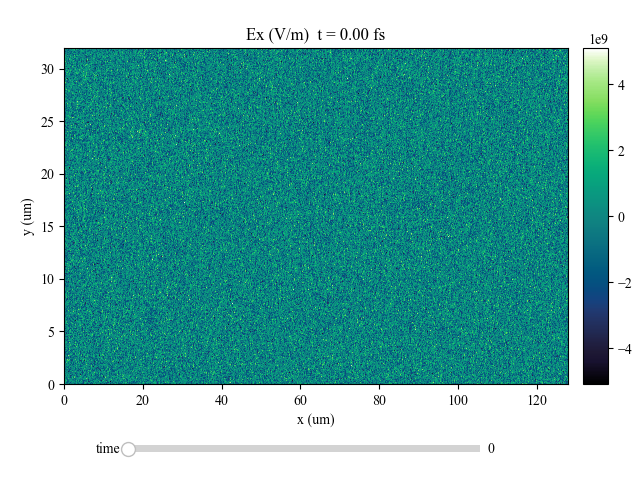

In [5]:
S.Field(0,'Ex',units=['cm^-3','kg/m^3','fs','um','V/m']).slide()

In [8]:
def check_fft(wkdir, case, num, var, time, shift=False, drawplot=False):
    '''
    check the fft of the variable, for a given case at a give time
    input:
        wkdir0: output directory
        case: S0/S1/etc
        num : 0/1/etc
        var : 'Ex'/'Ey'/etc
        // unit: 'units=['ps', 'um', 'V/m']', etc
        time: from the getTimesteps
        middle: logic, default false and sample the whole box
    '''
    
    twopi = 2.0*np.pi
    var0_time = case.Field(num, var, units=['ps']).getTimesteps()
    print('timesteps of var : ', var0_time)
    print('num. of timesteps: ', var0_time.size)
    
    var0 = case.Field(num, var, units=['ps']).getData(timestep=var0_time[time])[0]
    print('shape of var: ', var0.shape)
    
    var0_time_real = case.Field(num, var, units=['ps']).getTimes()
    print('time of var : {:.2f} ps'.format(var0_time_real[time]))
    
    xx = case.Field(num, var, units=['ps','um']).getAxis('x')
    yy = case.Field(num, var, units=['ps','um']).getAxis('y')
    
    var0_t = var0.transpose()/case.namelist.a_0
    
    if shift==True:
        nx = var0_t.shape[0]
        ny = var0_t.shape[1]
        sf = 200 # shift of cells to get rid of boundary condition
        print('note that the sample region is shifted to get rid of the BC issue')
        print('No. of cells being shifted, ', sf)
#         print(nx, ny)
        var0_t = var0_t[sf:(nx-sf),sf:(ny-sf)]
    
    dx = xx[1] - xx[0]
    dy = yy[1] - yy[0]
    
    Nx=np.shape(var0_t)[0]
    Ny=np.shape(var0_t)[1]

    kx=np.linspace(-Nx/2,Nx/2-1,Nx)/((Nx)*dx)  ## -1? min&max??
    ky=np.linspace(-Ny/2,Ny/2-1,Ny)/((Ny)*dy)

    var0_t_fft       = np.fft.fft2(var0_t)/Nx/Ny*2  ## Note: Normalization
    var0_t_fft_shift = np.fft.fftshift(var0_t_fft)
    
    var0_tosum = np.abs(np.flip(var0_t_fft_shift,1))
    
    var0_limit = np.maximum(var0_t.max(),np.abs(var0_t.min()))
    
    if drawplot==True:
        fig=plt.figure(figsize=(8,6))
        ax=fig.add_subplot(111)

        im=ax.imshow(var0_t,
    #                  extent=[xx.min()/twopi,xx.max()/twopi,yy.min()/twopi,yy.max()/twopi],
                     extent=[xx.min(),xx.max(),yy.min(),yy.max()],
                     vmin= -var0_limit,
                     vmax= var0_limit,
                     cmap='seismic',
                    )
        divider=make_axes_locatable(ax)
        width=axes_size.AxesY(ax,aspect=0.05)
        pad=axes_size.Fraction(0.5,width)
        cax=divider.append_axes("right",size=width,pad=pad)
        cbar = fig.colorbar(im,cax=cax)
        cbar.ax.set_ylabel(var+'$/E_0$')
        ax.set_xlabel(r'x ($\mu m$)')
        ax.set_ylabel(r'y ($\mu m$)')
        ax.set_title('time = {:.2f} ps'.format(var0_time_real[time]), fontsize=18)
        if shift== True:
            fig.savefig(wkdir+var+'_shift_'+str(var0_time_real[time])+'.png', dpi=100) 
        else:
            fig.savefig(wkdir+var+'_'+str(var0_time_real[time])+'.png', dpi=100)   
        plt.close()
    
#     var_t_inte = np.sum()
    
        fig=plt.figure(figsize=(8,6))
        ax=fig.add_subplot(111)

    #     im=ax.imshow(np.abs(np.flip(var0_t_fft_shift,1)),
        im=ax.imshow(np.log10(np.abs(np.flip(var0_t_fft_shift,1))),             
               cmap=newcmap, #newcmap, #"hot_r",
                     vmin=-4,
                     vmax=-1,
               extent=[kx.min(),kx.max(),ky.min(),ky.max()]
              )
        divider=make_axes_locatable(ax)
        width=axes_size.AxesY(ax,aspect=0.05)
        pad=axes_size.Fraction(0.5,width)
        cax=divider.append_axes("right",size=width,pad=pad)
        cbar = fig.colorbar(im,cax=cax)
    #     cbar.ax.set_ylabel(r'$E_x/E_0$')
        ax.set_xlabel('$k_xc/\omega_0$')
        ax.set_ylabel('$k_yc/\omega_0$')
        ax.set_xlim([-3.0,3.0])
        ax.set_ylim([-3.0,3.0])
        ax.set_title('FFT of '+var+' at time = {:.2f} ps'.format(var0_time_real[time]), fontsize=18)
        if shift==True:
            fig.savefig(wkdir+var+'_shift_fft_log_'+str(var0_time_real[time])+'.png', dpi=100) 
        else:
            fig.savefig(wkdir+var+'_fft_log_'+str(var0_time_real[time])+'.png', dpi=100) 
        plt.close()
    
    return var0_t, xx, yy, var0_time_real[time], var0_t_fft, var0_tosum, kx, ky


def inte_over_region(fft_arr, region, k_range, time, ave=False):
    
    nx_min = int((region[0] - k_range[0].min())/(k_range[0].max()-k_range[0].min())*k_range[0].size)
    nx_max = int((region[1] - k_range[0].min())/(k_range[0].max()-k_range[0].min())*k_range[0].size)
    ny_min = int((region[2] - k_range[1].min())/(k_range[1].max()-k_range[1].min())*k_range[1].size)
    ny_max = int((region[3] - k_range[1].min())/(k_range[1].max()-k_range[1].min())*k_range[1].size)
    
    ave = 1.0
    if ave == True:
        ave = (nx_max-nx_min)*(ny_max-ny_min)
    
    return np.sum(fft_arr[nx_min:nx_max,ny_min:ny_max])/ave

In [ ]:
## Using FFT-Ey to check R_SRS
num = S1.Field(1,'Ey').getTimes().size

x_srs_min  =  0.78
x_srs_max  =  0.82
y_srs_min  = -0.02
y_srs_max  =  0.02
region_srs  = [x_srs_min, x_srs_max, y_srs_min, y_srs_max]

x_inc_min  =  0.98
x_inc_max  =  1.02
y_inc_min  = -0.02
y_inc_max  =  0.02
region_inc  = [x_inc_min, x_inc_max, y_inc_min, y_inc_max]

E_SRS_B0 = np.zeros(num)
E_inc_B0 = np.zeros(num)
R_SRS_B0 = np.zeros(num)

for i in range(num):
    print('i = ', i)
    Ex0_t, xx0, yy0, time_real0, Ex0_t_fft, Ex0_t_fft_tosum, kx0, ky0 = \
    check_fft(wkdir[1], S1, 1, 'Ey', i, shift=False, drawplot=True)
        
    E_SRS_B0[i] = inte_over_region(Ex0_t_fft_tosum, region_srs, [kx0, ky0], i, ave=True)
    E_inc_B0[i] = inte_over_region(Ex0_t_fft_tosum, region_inc, [kx0, ky0], i, ave=True)
    if i > 0:
        R_SRS_B0[i] =  (E_SRS_B0[i] / E_inc_B0[i])**2
        print('R = ', R_SRS_B0[i])

In [ ]:
tt = S1.Field(1,'Ey',units=['ps']).getTimes()
plt.style.use('seaborn-poster')
# plt.plot(tt,R_SRS_B20,'-r', label='B = 20 T')
plt.plot(tt,R_SRS_B0,'--b', label='B = 0')
plt.xlabel('time (ps)')
plt.ylabel('R')
plt.legend()
plt.grid(linestyle='--',alpha=0.5)
# plt.title('an enhancement of {:.2f} times'.format(np.sum(strength_B20)/np.sum(strength_B0)))
plt.xlim([tt[0],tt[-1]])
plt.show()
# plt.savefig(wkdir[1]+'SRS_evo.png',dpi=600)

In [ ]:
## FFT

num = S0.Field(0,'Ex').getTimes().size

x_min  =  1.5
x_max  =  2.5
# y_min  = -2.0
# y_max  =  2.0

# x_min  =  1.0
# x_max  =  2.0
y_min  = -2.0
y_max  =  2.0
region  = [x_min, x_max, y_min, y_max]

strength_B0_n2 = np.zeros(num)

for i in range(num):
    print('i = ', i)
    Ex0_t, xx0, yy0, time_real0, Ex0_t_fft, Ex0_t_fft_tosum, kx0, ky0 = \
    check_fft(wkdir[0], S0, 0, 'Ex', i, shift=False, drawplot=True)
        
    strength_B0_n2[i] = inte_over_region(Ex0_t_fft_tosum, region, [kx0, ky0], i)
    print(strength_B0_n2[i])

np.save(wkdir[0]+'strength_SRS', strength_B0_n2)
    

In [24]:
## FFT

num = S0.Field(0,'Ex').getTimes().size

x_min  =  1.5
x_max  =  2.5
# y_min  = -2.0
# y_max  =  2.0

# x_min  =  1.0
# x_max  =  2.0
y_min  = -2.0
y_max  =  2.0
region  = [x_min, x_max, y_min, y_max]

strength_B20_n2 = np.zeros(num)

for i in range(num):
    print('i = ', i)
    Ex0_t, xx0, yy0, time_real0, Ex0_t_fft, Ex0_t_fft_tosum, kx0, ky0 = \
    check_fft(wkdir[1], S1, 0, 'Ex', i, shift=False, drawplot=True)
        
    strength_B20_n2[i] = inte_over_region(Ex0_t_fft_tosum, region, [kx0, ky0], i)
    print(strength_B20_n2[i])

np.save(wkdir[1]+'strength_SRS', strength_B20_n2)

i =  0
timesteps of var :  [    0.   735.  1470.  2205.  2940.  3675.  4410.  5145.  5880.  6615.
  7350.  8085.  8820.  9555. 10290. 11025. 11760. 12495. 13230. 13965.
 14700. 15435. 16170. 16905. 17640. 18375. 19110. 19845. 20580. 21315.
 22050. 22785. 23520. 24255. 24990. 25725. 26460. 27195. 27930. 28665.
 29400. 30135. 30870. 31605. 32340. 33075. 33810. 34545. 35280. 36015.
 36750. 37485. 38220. 38955. 39690. 40425. 41160. 41895. 42630. 43365.
 44100. 44835. 45570. 46305. 47040. 47775. 48510. 49245. 49980. 50715.
 51450. 52185. 52920. 53655. 54390. 55125. 55860. 56595. 57330. 58065.
 58800. 59535. 60270. 61005. 61740. 62475. 63210. 63945. 64680. 65415.
 66150. 66885. 67620. 68355. 69090. 69825. 70560. 71295. 72030. 72765.
 73500. 74235. 74970. 75705. 76440. 77175. 77910. 78645. 79380. 80115.
 80850. 81585. 82320. 83055. 83790. 84525. 85260. 85995. 86730. 87465.
 88200. 88935. 89670. 90405. 91140. 91875. 92610. 93345. 94080. 94815.
 95550.]
num. of timesteps:  131
shape of var:  (4

In [25]:
strength_B0 = np.load(wkdir[0]+'strength_SRS.npy')

In [27]:
strength_B20 = np.load(wkdir[1]+'strength_SRS.npy')

In [28]:
tt = S1.Field(0,'Ex',units=['ps']).getTimes()
plt.style.use('seaborn-paper')
plt.plot(tt,strength_B20,'-r', label='B = 20 T, total = {:.2f}'.format(np.sum(strength_B20)))
plt.plot(tt,strength_B0,'--b', label='B = 0, total = {:.2f}'.format(np.sum(strength_B0)))
plt.xlabel('time (ps)')
plt.ylabel('SRS signal (?)')
plt.legend()
plt.grid(linestyle='--',alpha=0.5)
plt.title('an enhancement of {:.2f} times'.format(np.sum(strength_B20)/np.sum(strength_B0)))
plt.xlim([tt[0],tt[-1]])
# plt.savefig(wkdir[1]+'SRS_evo.pdf',dpi=600)

/var/folders/px/lygg4lfs0b52bcyl348z_33c0000gp/T/ipykernel_36466/2075619858.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


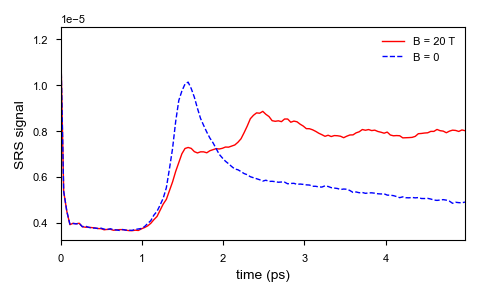

In [34]:
width = 3.2 * 1.5
height = width * 0.618
fig, axs = plt.subplots()


axs.plot(tt,strength_B20,'-r', lw = 1.0, 
         # markersize=8, fillstyle='none', markeredgewidth=2,
          label='B = 20 T')

axs.plot(tt,strength_B0,'--b', lw = 1.0, 
         # markersize=8, fillstyle='none', markeredgewidth=2,
         label='B = 0')

# axs.set_yscale('log')
axs.set_xlabel('time (ps)')
axs.set_xlim([tt[0],tt[-1]])
# axs.set_ylim([1e-2,1.0])
axs.set_ylabel('SRS signal')
# axs.set_title('filter between: '+str(filter_min)+' and '+str(filter_max),fontsize=14)
# axs.set_ylim([1e-3,1e0])
# axs.grid(linestyle='--',alpha=0.5)
axs.legend(frameon=False)
fig.set_size_inches(width, height)
fig.tight_layout()
plt.show()
fig.savefig('/Users/yao/Desktop/simulation_signal.png',dpi=600)

In [29]:
tt

array([0.        , 0.03828125, 0.0765625 , 0.11484375, 0.153125  ,
       0.19140625, 0.2296875 , 0.26796875, 0.30625   , 0.34453125,
       0.3828125 , 0.42109375, 0.459375  , 0.49765625, 0.5359375 ,
       0.57421875, 0.6125    , 0.65078125, 0.6890625 , 0.72734375,
       0.765625  , 0.80390625, 0.8421875 , 0.88046875, 0.91875   ,
       0.95703125, 0.9953125 , 1.03359375, 1.071875  , 1.11015625,
       1.1484375 , 1.18671875, 1.225     , 1.26328125, 1.3015625 ,
       1.33984375, 1.378125  , 1.41640625, 1.4546875 , 1.49296875,
       1.53125   , 1.56953125, 1.6078125 , 1.64609375, 1.684375  ,
       1.72265625, 1.7609375 , 1.79921875, 1.8375    , 1.87578125,
       1.9140625 , 1.95234375, 1.990625  , 2.02890625, 2.0671875 ,
       2.10546875, 2.14375   , 2.18203125, 2.2203125 , 2.25859375,
       2.296875  , 2.33515625, 2.3734375 , 2.41171875, 2.45      ,
       2.48828125, 2.5265625 , 2.56484375, 2.603125  , 2.64140625,
       2.6796875 , 2.71796875, 2.75625   , 2.79453125, 2.83281

In [35]:
b20 = S0.ParticleBinning(0,units=['um','ps','km/s','cm^-3','V/m'],
                  cmap=newcmap,
                    data_log=True,
                            vmin=-4.0,
                            vmax=0.0,
                         # ymin=-0.2,
                         # ymax=0.2,
                  )

b0 = S1.ParticleBinning(0,units=['um','ps','km/s','cm^-3','V/m'],
                  cmap=newcmap,
                    data_log=True,
                        vmin=-4.0,
                            vmax=0.0,
                        # ymin=-0.2,
                         # ymax=0.2,
                  )

happi.multiSlide(b0, b20, shape=[2,1],
                # skipAnimation=True,
               # saveAs='/Users/yao/Desktop/MLPI3D.pdf',dpi=600
               )

/Users/yao/Smilei/happi/_Diagnostics/Diagnostic.py:865: RuntimeWarning: divide by zero encountered in log10
  return self._np.log10( self._dataLinAtTime(t) )
